## Use model in notebook from cpu (from use_model_real_cuda.py)
added by Shooby Sep 6th. <br>
Last edit: Sep 18th

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np

In [3]:
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
kern = create_matching_kernel(psf,psf_hsc)
psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()


dataroot = 'gals_blend/' # path to dataset
workers = 4
batchSize = 64          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 100
ngpu = 3       #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
           # nn.BatchNorm2d(ngf * 4),
           # nn.ReLU(True),
  
            #nn.ConvTranspose2d(ngf*4, nc, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1


netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_blended_700.pth',map_location='cpu'))


<All keys matched successfully>

torch.Size([1, 1, 65, 65])


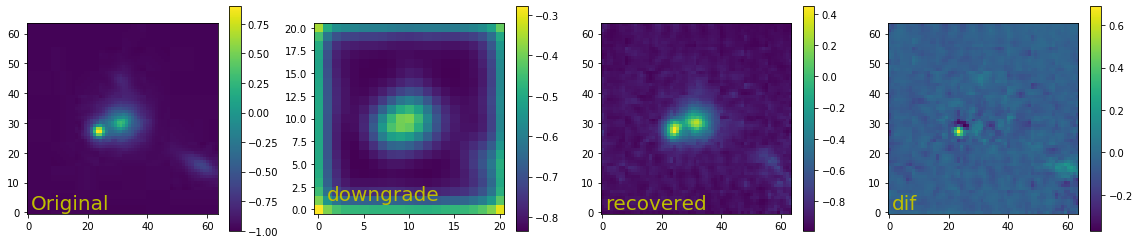

In [61]:

### read in an image with HST resoluion and downgrade (resample, PSF convolve, add noise) to HSC 
dataset = dset.MNIST(root=dataroot, download=True, transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=int(workers))

inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to(device)
ajab = real_cpu.detach()
ajab = ajab.cpu()

im = real_cpu+0.25*torch.rand_like(real_cpu)
downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
img = img[:,:,:,:]

fake = netS(img)
print(fake.shape)
fd = fake.detach()
fd = fd[:,:,:-1,:-1]
img = img.cpu()
fd = fd.cpu()
plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(ajab[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'Original',color='y',size=20)
plt.subplot(1,4,2)
plt.imshow(img[0,0,:,:],origin='lower')
plt.colorbar()
""
plt.text(1,1,'downgrade',color='y',size=20)
plt.subplot(1,4,3)
plt.imshow(fd[0,0,:,:],origin='lower')
plt.colorbar()

plt.text(1,1,'recovered',color='y',size=20)
plt.subplot(1,4,4)
plt.imshow((ajab[0,0,:,:]-fd[0,0,:,:]),origin='lower')
plt.colorbar()
plt.text(1,1,'dif',color='y',size=20)

plt.tight_layout()